## Utterance Waves

In [134]:
%load_ext autoreload
%autoreload 2
%pylab inline
import os
os.sys.path.append('../')
from data_loader import SpectrogramDatasetPair, AudioDataLoaderPair

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
import numpy as np
import random

speaker_wavs = {}
with open("../../../dataset/Identification_split.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        set_id, file_path = line.split()
        speaker, file_name = file_path.split('/')
        if speaker not in speaker_wavs:
            speaker_wavs[speaker] = [file_path]
        else:
            speaker_wavs[speaker].append(file_path)

### Scoring & Ranking Negative Pairs

Choose the resonable number of speaker

Fully scoring for Negative Pairs

50% Random Negative Pair + 50% hard Negative Pair from top 10% pair

In [ ]:
all_speakers = list(speaker_wavs.keys())
enroll_spk_size = 5
test_spk_size = 10
dev_uttrs_rate = 0.6
enroll_uttrs_rate = 0.8
test_uttrs_rate = 0.2

In [ ]:
E_speakers = [spk for spk in speaker_wavs.keys() if spk[0] == 'E']
# random_speakers = np.random.choice(E_speakers, enroll_spk_size + test_spk_size, replace=False)
enrolled_speakers = E_speakers[:enroll_spk_size]
test_speakers = E_speakers[enroll_spk_size:enroll_spk_size+test_spk_size]

speaker_id = {}
n_classes = enroll_spk_size
for i, spk in enumerate(enrolled_speakers):
    speaker_id[spk] = i

In [ ]:
enroll_X, enroll_y = [], []
test_X, test_y = [], []

for spk in enrolled_speakers:
    wavs = speaker_wavs[spk]
    video_names = []
    for wav_path in wavs:
        video_names.append(wav_path.split('/')[1].split('_000')[0])
    video_names = set(video_names)
    total_video = len(video_names)
    enroll_set = random.choices(list(video_names), k=int(total_video*enroll_uttrs_rate))
    test_set = list(video_names - set(enroll_set))
    for wav_path in wavs:
        video_name = wav_path.split('/')[1].split('_000')[0]
        if video_name in enroll_set:
            enroll_X.append(wav_path)
            enroll_y.append(speaker_id[spk])
        else:
            test_X.append(wav_path)
            test_y.append(speaker_id[spk])
enroll_X = np.array(enroll_X)
enroll_y = np.array(enroll_y)

In [ ]:
import config
audio_conf = config.audio_conf

In [ ]:
import itertools 
speaker_pairs = itertools.combinations(enrolled_speakers,2)
wav_pairs = []
for a, b in speaker_pairs:
    a_wav = enroll_X[enroll_y == speaker_id[a]]
    b_wav = enroll_X[enroll_y == speaker_id[b]]
    wav_pairs += list(itertools.product(a_wav, b_wav))

In [ ]:
base_dir = '/home/muncok/DL/dataset/voxceleb/'
with open('negative_sampling_manifest.csv', 'w') as f:
    for wav1, wav2 in wav_pairs:
        line = ','.join([base_dir+wav1, base_dir+wav2, '0'])
        f.write(line)
        f.write('\n')

In [ ]:
sample_rate = 16000
window_size = 0.025
window_stride = 0.01
window = 'hamming'
noise_dir = None
noise_prob = 0.4
noise_min = 0.0
noise_max = 0.5
vox_dir = "/home/ideal_kar/Dataset/voxceleb/"
split_file = '../../../dataset/voxceleb/Identification_split.txt'
audio_conf = dict(sample_rate=sample_rate,                                                                                                                                                            
                       window_size=window_size,                                                                                                                                                            
                       window_stride=window_stride,                                                                                                                                                        
                       window=window,                                                                                                                                                                      
                       noise_dir=noise_dir,                                                                                                                                                                
                       noise_prob=noise_prob,                                                                                                                                                              
                       noise_levels=(noise_min, noise_max))   

train_dataset = SpectrogramDatasetPair(audio_conf=audio_conf, manifest_filepath='negative_sampling_manifest.csv',
                                                   labels=None, normalize=True, augment=False)
train_loader = AudioDataLoaderPair(train_dataset, batch_size=32, num_workers=16,
                                    shuffle=False)

In [ ]:
from model import siameseNet, voxNet
from train_veri import load_pretrained_model, to_np
import torch
model = siameseNet(256)
model = load_pretrained_model(model, "../saved_models/iden/model_best_TestPOI.pth.tar")
model.cuda()
model.eval()

In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F
train_dists = np.empty(0)
label_list = np.empty(0)
for i, ((input0, input1), labels) in enumerate(train_loader):
    input0,input1,labels=  Variable(input0.cuda(), requires_grad=False), \
                           Variable(input1.cuda(), requires_grad=False), \
                           Variable(labels.cuda(), requires_grad=False)
    output0, output1 = model(input0, input1, 'fc8')
    torch.cuda.synchronize()

    train_dist = F.pairwise_distance(output0, output1)
    train_dists = np.append(train_dists, to_np(train_dist))
    label_list = np.append(label_list, to_np(labels))
    del output0, output1, train_dist

### Make Train Verification Manifest

In [ ]:
AllNegPairs = train_dataset.ids.copy()
sorted_idx = np.argsort(train_dists)

In [ ]:
import math
hard_percent = 0.1
hard_negSamples = AllNegPairs[:math.ceil(len(sorted_idx) * hard_percent)]
normal_negSamples = AllNegPairs[math.ceil(len(sorted_idx) * hard_percent):]

In [ ]:
posSamples = []
for spk in enrolled_speakers:
    wavs = enroll_X[enroll_y == speaker_id[spk]]
    posSamples += list(itertools.combinations(wavs, 2))

In [ ]:
import random
posSize = len(posSamples)
negSamples = random.choices(hard_negSamples, k=int(posSize/2)) + random.choices(normal_negSamples, k=int(posSize/2))

In [ ]:
base_dir = '/home/muncok/DL/dataset/voxceleb/'
with open('voxc_train_very_manifest.csv', 'w') as f:
    for wav1, wav2 in posSamples:
        line = ','.join([base_dir+wav1, base_dir+wav2, '1'])
        f.write(line)
        f.write('\n')
    for negPair in negSamples:
        line = ','.join(negPair)
        f.write(line)
        f.write('\n')

### Make Test Verification Manifest

In [ ]:
speaker_pairs = itertools.combinations(enrolled_speakers,2)
neg_wav_pairs = []
test_X = np.array(test_X)
test_y = np.array(test_y)
for a, b in speaker_pairs:
    a_wav = test_X[test_y == speaker_id[a]]
    b_wav = test_X[test_y == speaker_id[b]]
    neg_wav_pairs += list(itertools.product(a_wav, b_wav))
    
pos_wav_pairs = []
for spk_id i n speaker_id.values():
    wavs = test_X[test_y == spk_id]
    pos_wav_pairs += list(itertools.combinations(wavs, 2))

In [ ]:
test_posSamples = random.choices(pos_wav_pairs, k=posSize)
test_negSamples = random.choices(neg_wav_pairs, k=posSize)

In [ ]:
base_dir = '/home/muncok/DL/dataset/voxceleb/'
with open('voxc_test_very_manifest.csv', 'w') as f:
    for wav1, wav2 in test_posSamples:
        line = ','.join([base_dir+wav1, base_dir+wav2, '1'])
        f.write(line)
        f.write('\n')
    for  wav1, wav2 in test_negSamples:
        line = ','.join([base_dir+wav1, base_dir+wav2, '0'])
        f.write(line)
        f.write('\n')

In [ ]:
len(posSamples)

In [ ]:
len(negSamples)

### Speech_Command Negative Sampling

In [107]:
from sklearn.metrics import roc_curve, auc
def roc_auc_eer(dists, labels):
    """
        dists: 1D-Array, [samples]
        labels: 1D-Array, [samples]
    """
    fpr, tpr, thres = roc_curve(labels, dists, pos_label=1)
    roc_auc = auc(fpr, tpr)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    roc_bundle = {'fpr':fpr, 'tpr':tpr, 'thres':thres}
    np.save(open('roc_data.npy', 'wb'), roc_bundle)

    return roc_auc, eer

In [171]:
sample_rate = 16000
window_size = 0.025
window_stride = 0.01
window = 'hamming'
noise_dir = None
noise_prob = 0.4
noise_min = 0.0
noise_max = 0.5
batch_size = 16
audio_conf = dict(sample_rate=sample_rate,                                                                                                                                                            
                       window_size=window_size,                                                                                                                                                            
                       window_stride=window_stride,                                                                                                                                                        
                       window=window,                                                                                                                                                                      
                       noise_dir=noise_dir,                                                                                                                                                                
                       noise_prob=noise_prob,                                                                                                                                                              
                       noise_levels=(noise_min, noise_max))   

pos_dataset = SpectrogramDatasetPair(audio_conf=audio_conf, 
                                       manifest_filepath='../data/sv_reddot_pospair_manifest.csv',
                                       labels=None, normalize=True, augment=False)
pos_loader = AudioDataLoaderPair(pos_dataset, batch_size=batch_size, num_workers=16,
                                    shuffle=False)

neg_dataset = SpectrogramDatasetPair(audio_conf=audio_conf, 
                                       manifest_filepath='../data/sv_reddot_negpair_manifest.csv',
                                       labels=None, normalize=True, augment=False)
neg_loader = AudioDataLoaderPair(neg_dataset, batch_size=batch_size, num_workers=16,
                                    shuffle=False)

In [172]:
from torch.autograd import Variable
from model import siameseNet, mVoxNet, voxNet
import torch.nn.functional as F
from train_veri import load_pretrained_model
import torch
# model = voxNet(190)
# model.load_state_dict(torch.load('../models/model_best_300length.pth.tar')['state_dict'])
model = mVoxNet(40)
model.load_state_dict(torch.load('../models/model_iden_okgoogle.pth.tar')['state_dict'])
# model = load_pretrained_model(model, "../models/model_iden_pregoogle.pth.tar")

model.cuda()
model.eval()

mVoxNet (
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (fc6): Conv2d(128, 512, kernel_size=[9, 1], stride=(1, 1))
  (fc6_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (fc7): Linear (512 -> 256)
  (fc7_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (fc8): Linear (256 -> 40)
)

In [173]:
pos_scores = np.zeros([pos_dataset.size])
neg_scores = np.zeros([neg_dataset.size])
for j, ((input0, input1), labels) in enumerate(pos_loader):
    input0,input1,labels= Variable(input0.cuda(), requires_grad=False), \
                           Variable(input1.cuda(), requires_grad=False), \
                           Variable(labels.cuda(), requires_grad=False)
    output0, output1 = model(input0, output_l='fc7'), model(input1, output_l='fc7')
    dists = F.cosine_similarity(output0, output1)
    del output0, output1
    pos_scores[j*batch_size: (j+1)*batch_size] = dists.cpu().data.numpy() 
    
for j, ((input0, input1), labels) in enumerate(neg_loader):
    input0,input1,labels= Variable(input0.cuda(), requires_grad=False), \
                           Variable(input1.cuda(), requires_grad=False), \
                           Variable(labels.cuda(), requires_grad=False)
    output0, output1 = model(input0, output_l='fc7'), model(input1, output_l='fc7')
    dists = F.cosine_similarity(output0, output1)
    del output0, output1
    neg_scores[j*batch_size: (j+1)*batch_size] = dists.cpu().data.numpy() 

In [174]:
dists = np.concatenate((pos_scores, neg_scores), 0)
labels = np.concatenate((np.ones_like(pos_scores), np.zeros_like(neg_scores)), 0)
roc_auc_eer(dists, labels)

(0.99345124716553279, 0.03619047619047619)

(array([  2.,   0.,   4.,  13.,  18.,  31.,  56.,  73.,  80.,  38.]),
 array([ 0.30476415,  0.37428776,  0.44381137,  0.51333498,  0.58285859,
         0.65238219,  0.7219058 ,  0.79142941,  0.86095302,  0.93047663,
         1.00000024]),
 <a list of 10 Patch objects>)

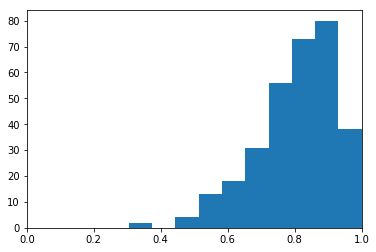

In [175]:
# no finetune
plt.xlim([0.0, 1.0])
plt.hist(pos_scores)

(array([ 54.,  95.,  90.,  90.,  68.,  50.,  32.,  30.,  10.,   6.]),
 array([ 0.02942065,  0.0968418 ,  0.16426295,  0.23168411,  0.29910526,
         0.36652641,  0.43394757,  0.50136872,  0.56878987,  0.63621102,
         0.70363218]),
 <a list of 10 Patch objects>)

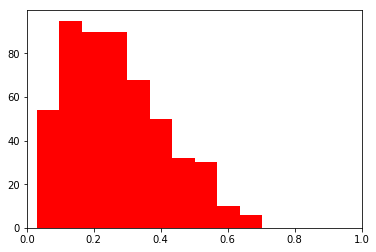

In [176]:
# finetune
plt.xlim([0.0, 1.0])
plt.hist(neg_scores, color='r')

In [69]:
hard_neg_idx = np.argwhere(scores > 0.45)
with open('../data/sv_command_negpair_manifest.csv', 'r') as f:
    lines = f.read().splitlines()

In [70]:
hard_neg_samples = np.array(lines)[hard_neg_idx].squeeze()

In [74]:
np.save(open("sv_command_hardneg_list.npy", 'wb'), hard_neg_samples)

In [72]:
import csv
with open('../data/sv_command_hardneg_manifest.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
    writer.writerow(hard_neg_samples)

(array([   85.,   482.,  1092.,  1229.,   983.,   629.,   291.,   120.,
           26.,    13.]),
 array([ 0.09451298,  0.15526532,  0.21601766,  0.27677   ,  0.33752234,
         0.39827468,  0.45902702,  0.51977936,  0.5805317 ,  0.64128404,
         0.70203638]),
 <a list of 10 Patch objects>)

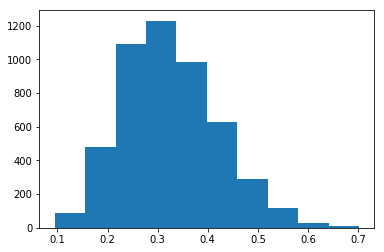

In [17]:
# spkears unseen during SI training
# Neg sampling
plt.hist(scores)

(array([   14.,    69.,   352.,  1192.,  3404.,  5829.,  4024.,  1168.,
          315.,    13.]),
 array([ 0.198135  ,  0.27584045,  0.3535459 ,  0.43125135,  0.5089568 ,
         0.58666226,  0.66436771,  0.74207316,  0.81977861,  0.89748406,
         0.97518951]),
 <a list of 10 Patch objects>)

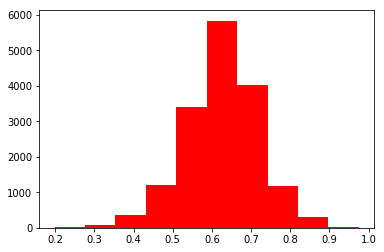

In [23]:
# spkears seen during SI training
# Pos sampling
plt.hist(scores,color='r')